In [1]:
import numpy as np
import matplotlib.pyplot as plt

import oqupy
import oqupy.operators as op

from scipy.optimize import minimize, Bounds
from typing import List,Tuple

# --- Parameters --------------------------------------------------------------

# -- time steps --
dt = 0.05 # 0.2
num_steps = 20 # 20

# -- bath --
alpha =  0.126 #0.08
omega_cutoff = 3.04 #4
temperature =  5 * 0.1309 #1.6
pt_dkmax =60 # 40
pt_epsrel = 10**(-7) #1.0e-5

# -- initial and target state --
initial_state = op.spin_dm('x-')
target_state = op.spin_dm('x+')

# -- initial parameter guess --
x0= np.zeros(num_steps)
z0 = np.ones(num_steps) * (np.pi) / (dt*num_steps)
'''
for i in range(len(z0)):
    if i % 2 == 0:
        z0[i]=0
'''

#parameter_list=[i[0] for i in zip(x0,z0)]

parameter_list=[item for pair in zip(x0, z0) for item in pair] # this makes a list without the inner tuples

#parameter_list = list(zip(x0,z0))
#num_params = len(parameter_list[0])

In [2]:
halfparalist=[item for item in zip(x0,z0) for i in range(2)]

In [3]:
# --- Compute process tensors -------------------------------------------------
correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=3,
                                cutoff=omega_cutoff,
                                cutoff_type='gaussian',
                                temperature=temperature)
bath = oqupy.Bath(oqupy.operators.sigma("z")/2, correlations)


pt_tempo_parameters = oqupy.TempoParameters(
    dt=dt,
    epsrel=pt_epsrel,
    dkmax=pt_dkmax)
process_tensor = oqupy.pt_tempo_compute(
    bath=bath,
    start_time=0.0,
    end_time=num_steps * dt,
    parameters=pt_tempo_parameters,
    progress_type='bar')

--> PT-TEMPO computation:
100.0%   20 of   20 [########################################] 00:00:00
Elapsed time: 0.4s


In [4]:
def hamiltonian(hx,hz):

    hx_sx = 0.5 * oqupy.operators.sigma('x') * hx
    hz_sz = 0.5 * oqupy.operators.sigma('z') * hz

    return hz_sz + hx_sx

parameterized_system=oqupy.ParameterizedSystem(hamiltonian)



In [5]:
import tensornetwork as tn

In [6]:
fsadj=oqupy.compute_gradient_and_dynamics(
        system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)[0][1]
firsthalfprop,secondhalfprop=parameterized_system.get_propagators(dt,halfparalist)(1)
fpt=tn.Node(firsthalfprop.T)
spt=tn.Node(secondhalfprop.T)
fsadj[0] ^ fpt[0]
fsadj[1] ^ fpt[1]
result1=fsadj @ fpt
print(result1.tensor)

21
[[ 0.2499993 -4.66359997e-16j -0.19708521-7.43323897e-02j
  -0.19708521+7.43323897e-02j  0.24999983-6.12421243e-18j]
 [-0.24166009+5.80173732e-02j  0.20930269+1.64724789e-02j
   0.17806491-1.09118316e-01j -0.24166005+5.80175259e-02j]
 [-0.24166009-5.80173732e-02j  0.17806491+1.09118316e-01j
   0.20930269-1.64724789e-02j -0.24166005-5.80175259e-02j]
 [ 0.24999983+4.21271836e-18j -0.20313677-5.57076148e-02j
  -0.20313677+5.57076148e-02j  0.2499993 +4.45793440e-17j]]


In [7]:
fsadj=oqupy.compute_gradient_and_dynamics(
        system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)[0][0]
firsthalfprop,secondhalfprop=parameterized_system.get_propagators(dt,halfparalist)(0)
fpt=tn.Node(firsthalfprop.T)
spt=tn.Node(secondhalfprop.T)
fsadj[2] ^ spt[0]
fsadj[3] ^ spt[1]
result2=fsadj @ spt
print(result2.tensor)

21
[[ 0.2499993 -4.66359782e-16j -0.20930269-1.64724789e-02j
  -0.20930269+1.64724789e-02j  0.2499993 +4.45792678e-17j]
 [-0.2499993 +4.66359782e-16j  0.20930269+1.64724789e-02j
   0.20930269-1.64724789e-02j -0.2499993 -4.45792678e-17j]
 [-0.2499993 +4.66359782e-16j  0.20930269+1.64724789e-02j
   0.20930269-1.64724789e-02j -0.2499993 -4.45792678e-17j]
 [ 0.2499993 -4.66359782e-16j -0.20930269-1.64724789e-02j
  -0.20930269+1.64724789e-02j  0.2499993 +4.45792778e-17j]]


In [8]:
bpl=oqupy.compute_gradient_and_dynamics(system=parameterized_system,
                                    parameters=halfparalist,
                                    initial_state=initial_state,
                                    target_state=target_state.T,
                                    process_tensor=process_tensor)

21


In [9]:
bpl[1]

In [10]:
parameterized_system.get_propagator_derivatives(dt,halfparalist)(0)[0][0]

array([[ 0.        +0.j        ,  0.00049062+0.01248715j,
         0.00049062-0.01248715j,  0.        +0.j        ],
       [ 0.00049062+0.01248715j,  0.        +0.j        ,
         0.        +0.j        , -0.00049062-0.01248715j],
       [ 0.00049062-0.01248715j,  0.        +0.j        ,
         0.        +0.j        , -0.00049062+0.01248715j],
       [ 0.        +0.j        , -0.00049062-0.01248715j,
        -0.00049062+0.01248715j,  0.        +0.j        ]])

In [11]:
parameterized_system.get_propagator_derivatives(dt,halfparalist)(1)[1][0]

array([[ 0.        +0.j        ,  0.00049062+0.01248715j,
         0.00049062-0.01248715j,  0.        +0.j        ],
       [ 0.00049062+0.01248715j,  0.        +0.j        ,
         0.        +0.j        , -0.00049062-0.01248715j],
       [ 0.00049062-0.01248715j,  0.        +0.j        ,
         0.        +0.j        , -0.00049062+0.01248715j],
       [ 0.        +0.j        , -0.00049062-0.01248715j,
        -0.00049062+0.01248715j,  0.        +0.j        ]])

In [12]:
bpl=oqupy.compute_gradient_and_dynamics(system=parameterized_system,
                                    parameters=halfparalist,
                                    initial_state=initial_state,
                                    target_state=target_state.T,
                                    process_tensor=process_tensor)[0]
props=parameterized_system.get_propagators(dt,halfparalist)
pds=parameterized_system.get_propagator_derivatives(dt,halfparalist)
thispara=0
resultlist=[]
for i in range(num_steps):
    fhprd,shprd=pds(i)
    fhprd=fhprd[thispara]
    shprd=shprd[thispara]
    fhprp,shprp=props(i)
    fpdt=tn.Node(fhprd.T)
    spdt=tn.Node(shprd.T)
    fpt=tn.Node(fhprp.T)
    spt=tn.Node(shprp.T)
    thisadjoint1=bpl[i] 
    thisadjoint2=tn.replicate_nodes([thisadjoint1])[0]
    thisadjoint1[0] ^ fpdt[0]
    thisadjoint1[1] ^ fpdt[1]
    thisadjoint1[2] ^ spt[0]
    thisadjoint1[3] ^ spt[1]
    result1=thisadjoint1 @ fpdt @ spt
    thisadjoint2[0] ^ fpt[0]
    thisadjoint2[1] ^ fpt[1]
    thisadjoint2[2] ^ spdt[0]
    thisadjoint2[3] ^ spdt[1]
    result2=thisadjoint2 @ spdt @ fpt
    resultlist.append((result1.tensor,result2.tensor))



21


In [17]:
eoinscode=oqupy.state_gradient(system=parameterized_system,
        initial_state=initial_state,
        target_state=target_state,
        process_tensor=process_tensor,
        parameters=halfparalist)

In [19]:
eoinscode['gradient']

array([[-8.85452913e-17+8.64445355e-19j, -7.93852831e-16-4.57167399e-16j],
       [ 2.42731992e-04-1.08216929e-17j, -7.93961251e-16-4.56286484e-16j],
       [ 2.39729661e-04-2.16501621e-17j, -7.93852831e-16-4.55419123e-16j],
       [ 4.71082653e-04-4.28327621e-17j, -7.93961251e-16-4.55412346e-16j],
       [ 4.59206461e-04-5.47047759e-17j, -7.93419150e-16-4.53650518e-16j],
       [ 6.61727323e-04-6.08034131e-17j, -7.93527570e-16-4.53650518e-16j],
       [ 6.35752669e-04-7.14048775e-17j, -7.95370714e-16-4.53691175e-16j],
       [ 7.94521571e-04-6.24839265e-17j, -7.95262294e-16-4.52823814e-16j],
       [ 7.50419778e-04-6.71459958e-17j, -7.95695974e-16-4.54572090e-16j],
       [ 8.54840653e-04-7.51081055e-17j, -7.95587554e-16-4.53697952e-16j],
       [ 7.90206571e-04-7.84115340e-17j, -7.93527570e-16-4.53630189e-16j],
       [ 8.35060008e-04-8.40256684e-17j, -7.93419150e-16-4.53623413e-16j],
       [ 7.49376543e-04-8.86470801e-17j, -7.95370714e-16-4.51922571e-16j],
       [ 7.35293894e-04-1

In [15]:
oqupy.forward_backward_propagation(
        parametrized_system,
        initial_state,
        target_state,
        process_tensor,
        parameters=halfparalist,
        dynamics_only=True)

AttributeError: module 'oqupy' has no attribute 'forward_backward_propagation'

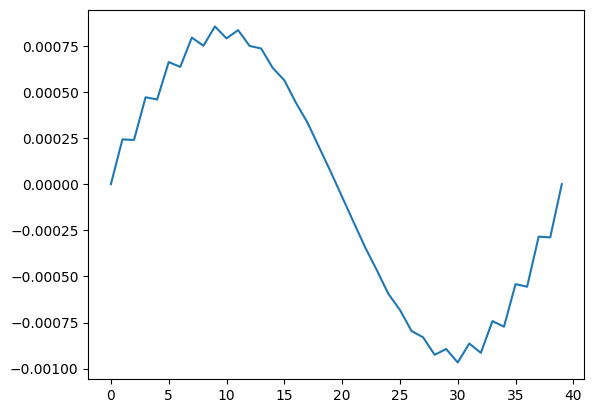

In [ ]:
plt.plot(eoinscode['gradient'][:,0])